In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Looking at dim_claims, dim_pa and bridge

In [2]:
claims = pd.read_csv('dim_claims.csv')
claims.columns

Index(['dim_claim_id', 'bin', 'drug', 'reject_code',
       'pharmacy_claim_approved'],
      dtype='object')

In [3]:
claims.bin.value_counts()
    

999001    640740
417614    307323
417740    213982
417380    173531
Name: bin, dtype: int64

In [4]:
claims.bin.isnull().values.any()

False

In [5]:
## Replace bin numbers with P1,P2,P3,P4
claims['Payer'] = claims['bin'].replace([999001, 417614, 417740, 417380],['P1','P2','P3','P4'])
claims.head()


,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,Payer
0,1,417380,A,75.0,0,P4
1,2,999001,A,NaN,1,P1
2,3,417740,A,76.0,0,P3
3,4,999001,A,NaN,1,P1
4,5,417740,A,NaN,1,P3


There are four different bins which represent four different payers (health insurance providers).

In [6]:
claims.drug.value_counts()

A    679283
B    342750
C    313543
Name: drug, dtype: int64

In [7]:
claims.drug.isnull().values.any()

False

There are 3 types of drugs. The instances of drug A are almost twice of drug B and C individually.

In [8]:
claims.reject_code.value_counts()

70.0    252206
75.0    217351
76.0     86394
Name: reject_code, dtype: int64

In [9]:
claims.reject_code.isnull().values.any()
claims.reject_code.isnull().sum()

779625

70: Drug not covered, not on formulary
75: Drug on formulary, requires PA
76: Drug covered, on formulary, plan limits exceeded.
Approved claims are identified as NaN values.

In [10]:
claims.pharmacy_claim_approved.value_counts()

1    779625
0    555951
Name: pharmacy_claim_approved, dtype: int64

In [11]:
claims.pharmacy_claim_approved.isnull().values.any()

False

In [12]:
pa = pd.read_csv('dim_pa.csv')
pa.columns
pa.head()

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1,1,0,1
1,2,1,0,0,1
2,3,0,0,1,1
3,4,1,1,0,1
4,5,0,1,0,1


This dataframe contains details on all the rejected claims in claims.

In [13]:
print(pa.correct_diagnosis.value_counts())
print(pa.correct_diagnosis.isnull().values.any())

1    444660
0    111291
Name: correct_diagnosis, dtype: int64
False


In [14]:
print(pa.tried_and_failed.value_counts())
print(pa.tried_and_failed.isnull().values.any())

1    278398
0    277553
Name: tried_and_failed, dtype: int64
False


In [15]:
print(pa.contraindication.value_counts())
print(pa.contraindication.isnull().values.any())

0    444315
1    111636
Name: contraindication, dtype: int64
False


In [16]:
print(pa.pa_approved.value_counts())
print(pa.pa_approved.isnull().values.any())

1    408319
0    147632
Name: pa_approved, dtype: int64
False


In [17]:
date = pd.read_csv('dim_date.csv')
date.columns

Index(['dim_date_id', 'date_val', 'calendar_year', 'calendar_month',
       'calendar_day', 'day_of_week', 'is_weekday', 'is_workday',
       'is_holiday'],
      dtype='object')

This gives information on date and flags such as weekday, weekend, holiday for claim records.

In [18]:
bridge = pd.read_csv('bridge.csv')
bridge.columns
bridge.head()

,dim_claim_id,dim_pa_id,dim_date_id
0,1,1.0,1
1,2,NaN,1
2,3,2.0,1
3,4,NaN,1
4,5,NaN,1


This dataframe helps to connect claims and pa dataframes using the ids.

# Questions we can ask

1. Given a certain drug, which features in the PA request(correct diagnosis, tried and failed, contraindication) makes approval more probable?
2. Do certain payers prefer a certain feature in the PA request for approval, irrespective of drug?
3. Does a particular drug require specific features in PA for approval irrespective of payer?
4. Which payer is more probable to add drugs to their formulary vs which payer is probable to approve PA once limit is reached (can help to suggest insurance plans to customers depending on their needs)
5. Does PA frequency at a particular time impact the approval probability? Is it preferrable to submit PAs at certain times vs others? is this behaviour same for all payers?

Let's look at data specific to drug A.

In [19]:
claims_A = claims.loc[claims['drug'] == 'A']
claims_A.drop(columns = ['bin','drug'])

,dim_claim_id,reject_code,pharmacy_claim_approved,Payer
0,1,75.0,0,P4
1,2,NaN,1,P1
2,3,76.0,0,P3
3,4,NaN,1,P1
4,5,NaN,1,P3
...,...,...,...,...
1334821,1334822,NaN,1,P1
1334822,1334823,NaN,1,P1
1334823,1334824,NaN,1,P1
1334824,1334825,NaN,1,P1


In [20]:
claims_A_P1 = claims_A.loc[claims_A['Payer']=='P1']
claims_A_P1.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,Payer
1,2,999001,A,NaN,1,P1
3,4,999001,A,NaN,1,P1
6,7,999001,A,NaN,1,P1
8,9,999001,A,NaN,1,P1
10,11,999001,A,76.0,0,P1


In [21]:
claims_A_P1['pharmacy_claim_approved'].value_counts()

1    293040
0     32492
Name: pharmacy_claim_approved, dtype: int64

In [22]:
payers = ['P1','P2','P3','P4']
for P in payers:
    claims_A_P = claims_A.loc[claims_A['Payer']== P]
    print("For payer",str(P))
    print(claims_A_P['pharmacy_claim_approved'].value_counts())

For payer P1
1    293040
0     32492
Name: pharmacy_claim_approved, dtype: int64
For payer P2
0    156497
Name: pharmacy_claim_approved, dtype: int64
For payer P3
1    97951
0    10817
Name: pharmacy_claim_approved, dtype: int64
For payer P4
0    88486
Name: pharmacy_claim_approved, dtype: int64


Payers P2 and P4 do not directly approve drug A so they do not have it on their formulary. Payers P1 and P4 seem to have it on the formulary but they also have rejected claims. Let's check for cause of rejections.

In [23]:
payers = ['P1','P2','P3','P4']
for P in payers:
    claims_A_P = claims_A.loc[claims_A['Payer']== P]
    print("For payer",str(P))
    print(claims_A_P['reject_code'].value_counts())

For payer P1
76.0    32492
Name: reject_code, dtype: int64
For payer P2
70.0    156497
Name: reject_code, dtype: int64
For payer P3
76.0    10817
Name: reject_code, dtype: int64
For payer P4
75.0    88486
Name: reject_code, dtype: int64


P1 rejected claims for drug A due to limit crossing, P2 due to drug not being on formulary, P3 due to limit crossing and P4 seems to just have a PA requirement to approve drug A.

We will use bridge.csv to stitch together dim_claims.csv and dim_pa.csv to get relationship between dim_claim_id and dim_pa_id. 

In [24]:
data_claims = pd.merge(bridge,claims,on='dim_claim_id')
data = pd.merge(data_claims,pa,on='dim_pa_id')
data.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,Payer,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1.0,1,417380,A,75.0,0,P4,1,1,0,1
1,3,2.0,1,417740,A,76.0,0,P3,1,0,0,1
2,10,3.0,1,417380,A,75.0,0,P4,0,0,1,1
3,11,4.0,1,999001,A,76.0,0,P1,1,1,0,1
4,15,5.0,1,417614,A,70.0,0,P2,0,1,0,1


# Plots to observe trends

Let's look at all the claim instances(pharmacy_claim approved/denied) for each drug per payer.

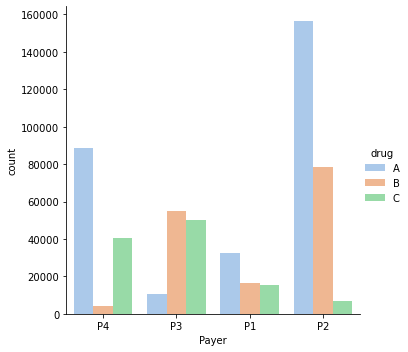

In [25]:
sns.catplot(x= "Payer", hue= "drug", kind= "count", palette= "pastel",data = data)

We have much more instances for drug A for P2 vs others. This can possibly bias the outcome in favor of preferences of P2.

Looking at the PA approval/denial counts for each drug per payer.

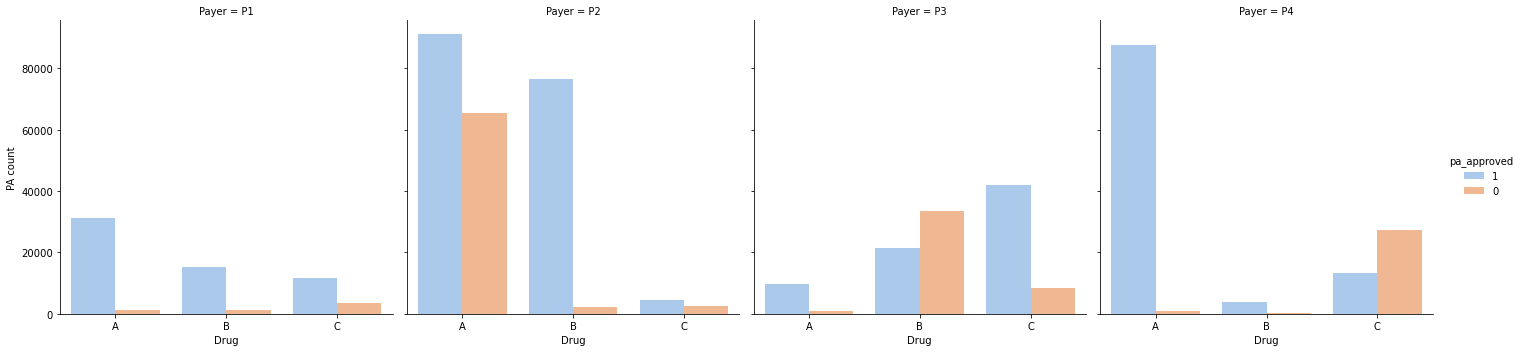

In [26]:

pa_plot=sns.catplot(x="drug", hue="pa_approved", kind="count",hue_order=[1,0],palette="pastel",col="Payer",col_order=['P1','P2','P3','P4'],data=data)
pa_plot.set_axis_labels("Drug","PA count")

## PA approval/denial for each PA info category

In [27]:
##CD:Correct Diagnosis, TF:Tried and Failed, CI:Contraindication
data_CD = data[data['correct_diagnosis']==1]
data_TF = data[data['tried_and_failed']==1]
data_CI = data[data['contraindication']==1]

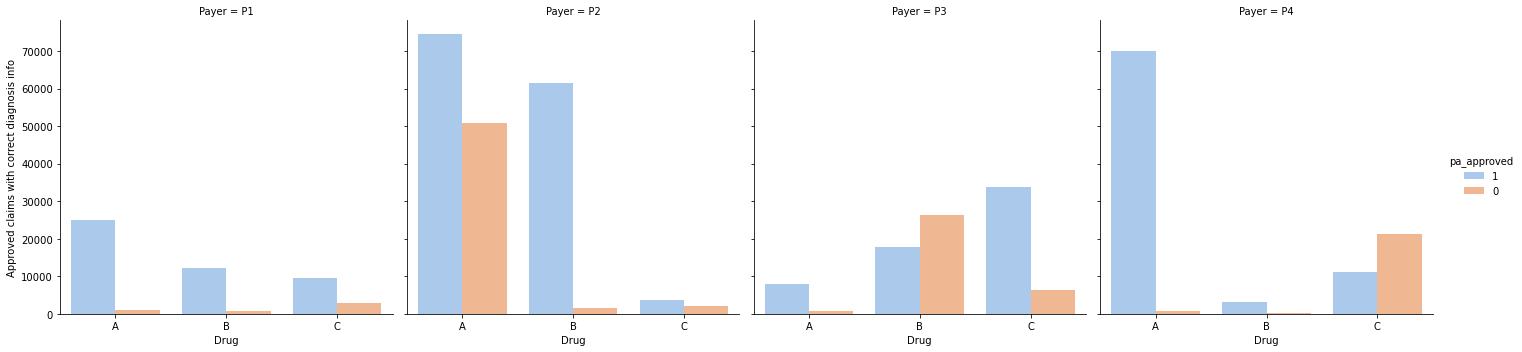

In [28]:
cd_plot = sns.catplot(x="drug", hue="pa_approved", kind="count",hue_order=[1,0],palette="pastel",col="Payer",col_order=['P1','P2','P3','P4'],data=data_CD)
cd_plot.set_axis_labels("Drug","Approved claims with correct diagnosis info")

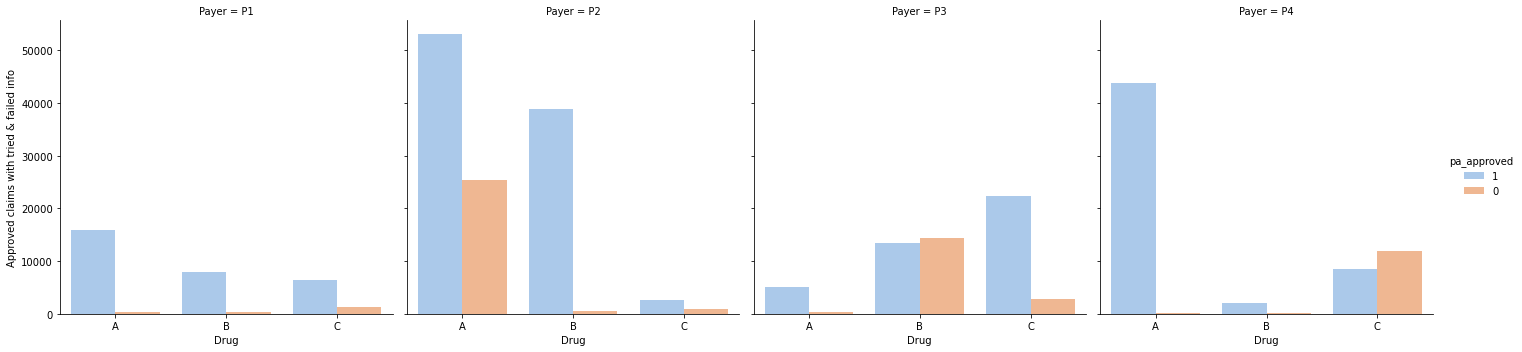

In [29]:
tf_plot = sns.catplot(x="drug", hue="pa_approved", kind="count",hue_order=[1,0],palette="pastel",col="Payer",col_order=['P1','P2','P3','P4'],data=data_TF)
tf_plot.set_axis_labels("Drug","Approved claims with tried & failed info")

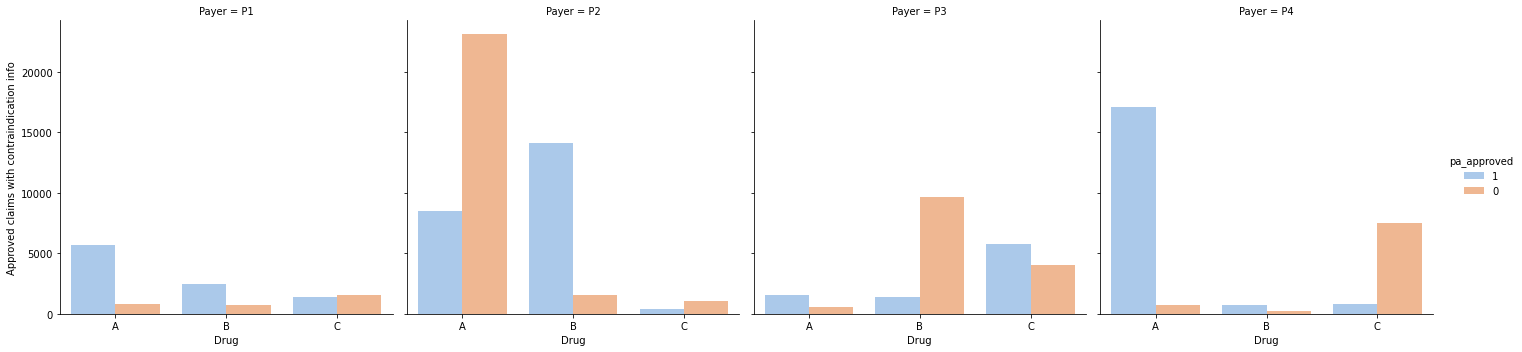

In [30]:
ci_plot = sns.catplot(x="drug", hue="pa_approved", kind="count",hue_order=[1,0],palette="pastel",col="Payer",col_order=['P1','P2','P3','P4'],data=data_CI)
ci_plot.set_axis_labels("Drug","Approved claims with contraindication info")

Look at approval rate for each payer with regard to each PA info feature. This will require us to convert the binary flag columns into a single categorical column with 8 categoricals. Correct Diagnosis:CD, Tried and Failed:TF, COntraindication:CI, CD+TF, TF+CI, CD+CI, CD+TF+CI, None. 

In [31]:
conditions = [(data['correct_diagnosis']==1)&(data['tried_and_failed']==0)&(data['contraindication']==0),
             (data['correct_diagnosis']==0)&(data['tried_and_failed']==1)&(data['contraindication']==0),
             (data['correct_diagnosis']==0)&(data['tried_and_failed']==0)&(data['contraindication']==1),
             (data['correct_diagnosis']==1)&(data['tried_and_failed']==1)&(data['contraindication']==0),
             (data['correct_diagnosis']==1)&(data['tried_and_failed']==0)&(data['contraindication']==1),
             (data['correct_diagnosis']==0)&(data['tried_and_failed']==1)&(data['contraindication']==1),
             (data['correct_diagnosis']==1)&(data['tried_and_failed']==1)&(data['contraindication']==1),
             (data['correct_diagnosis']==0)&(data['tried_and_failed']==0)&(data['contraindication']==0)]

In [32]:
values = ['CD','TF','CI','CD+TF','CD+CI','TF+CI','CD+TF+CI','None']

In [33]:
data['claim_reason'] = np.select(conditions,values)

In [34]:
data.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,Payer,correct_diagnosis,tried_and_failed,contraindication,pa_approved,claim_reason
0,1,1.0,1,417380,A,75.0,0,P4,1,1,0,1,CD+TF
1,3,2.0,1,417740,A,76.0,0,P3,1,0,0,1,CD
2,10,3.0,1,417380,A,75.0,0,P4,0,0,1,1,CI
3,11,4.0,1,999001,A,76.0,0,P1,1,1,0,1,CD+TF
4,15,5.0,1,417614,A,70.0,0,P2,0,1,0,1,TF


Looking at PA approvals for Drug A based on Claim info for each payer.

In [35]:
data_A = data[data['drug']=='A']
data_A.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,Payer,correct_diagnosis,tried_and_failed,contraindication,pa_approved,claim_reason
0,1,1.0,1,417380,A,75.0,0,P4,1,1,0,1,CD+TF
1,3,2.0,1,417740,A,76.0,0,P3,1,0,0,1,CD
2,10,3.0,1,417380,A,75.0,0,P4,0,0,1,1,CI
3,11,4.0,1,999001,A,76.0,0,P1,1,1,0,1,CD+TF
4,15,5.0,1,417614,A,70.0,0,P2,0,1,0,1,TF


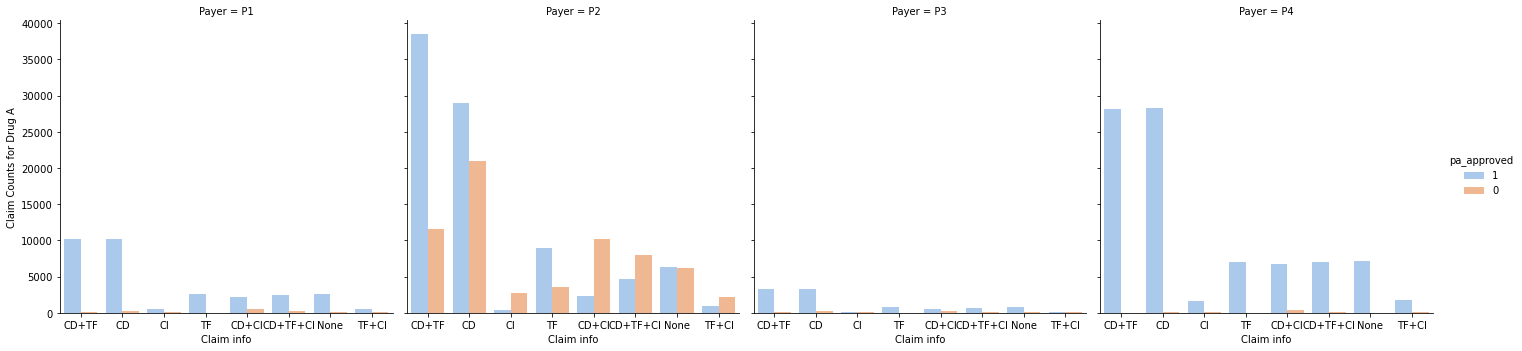

In [36]:
tf_plot = sns.catplot(x="claim_reason", hue="pa_approved", kind="count",hue_order=[1,0],palette="pastel",col="Payer",col_order=['P1','P2','P3','P4'],data=data_A)
tf_plot.set_axis_labels("Claim info","Claim Counts for Drug A")

Looking at PA approvals for Drug B based on Claim info for each payer.

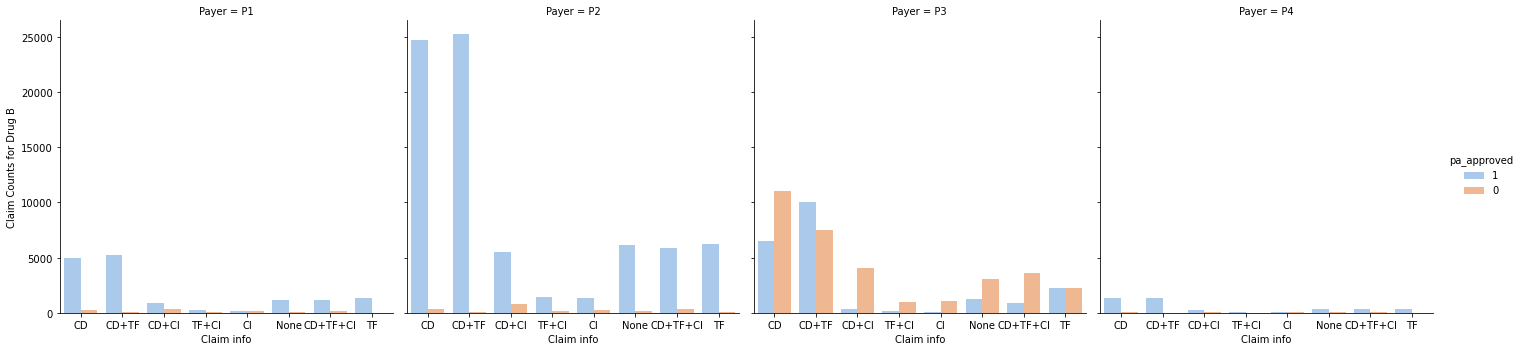

In [37]:
data_B = data[data['drug']=='B']
tf_plot = sns.catplot(x="claim_reason", hue="pa_approved", kind="count",hue_order=[1,0],palette="pastel",col="Payer",col_order=['P1','P2','P3','P4'],data=data_B)
tf_plot.set_axis_labels("Claim info","Claim Counts for Drug B")

Looking at PA approvals for Drug C based on Claim info for each payer.

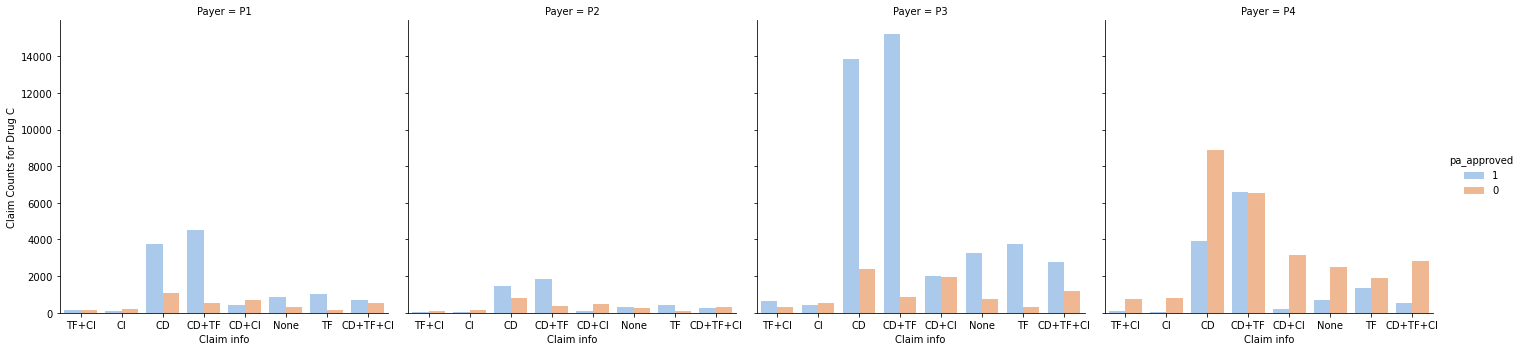

In [38]:
data_C = data[data['drug']=='C']
tf_plot = sns.catplot(x="claim_reason", hue="pa_approved", kind="count",hue_order=[1,0],palette="pastel",col="Payer",col_order=['P1','P2','P3','P4'],data=data_C)
tf_plot.set_axis_labels("Claim info","Claim Counts for Drug C")

In [39]:
data_A_CD = data_A[data_A['correct_diagnosis']==1]

In [41]:
data_A_CD['pa_approved'].mean()

0.7696242846047373

In [42]:
data_A_TF = data_A[data_A['tried_and_failed']==1]
data_A_TF['pa_approved'].mean()

0.8180751010655294

In [43]:
data_A_CI = data_A[data_A['contraindication']==1]
data_A_CI['pa_approved'].mean()

0.5659198843691926

In [44]:
data_B_CD = data_B[data_B['correct_diagnosis']==1]
data_B_CD['pa_approved'].mean()

0.7655937487347666

In [45]:
data_B_TF = data_B[data_B['tried_and_failed']==1]
data_B_TF['pa_approved'].mean()

0.8014579925554797

In [46]:
data_B_CI = data_B[data_B['contraindication']==1]
data_B_CI['pa_approved'].mean()

0.604732463664908

In [47]:
data_C_CD = data_C[data_C['correct_diagnosis']==1]
data_C_CD['pa_approved'].mean()

0.6415466713709232

In [48]:
data_C_TF = data_C[data_C['tried_and_failed']==1]
data_C_TF['pa_approved'].mean()

0.7021182933915585

In [49]:
data_C_CI = data_C[data_C['contraindication']==1]
data_C_CI['pa_approved'].mean()

0.37384540593096743

In [53]:
data_A_None = data_A[(data_A['correct_diagnosis']==0)&(data_A['tried_and_failed']==0)&(data_A['contraindication']==0)]
data_A_None['pa_approved'].mean()

0.7242169925592663

In [54]:
data_B_None = data_B[(data_B['correct_diagnosis']==0)&(data_B['tried_and_failed']==0)&(data_B['contraindication']==0)]
data_B_None['pa_approved'].mean()

0.7315124337545862

In [55]:
data_C_None = data_C[(data_C['correct_diagnosis']==0)&(data_C['tried_and_failed']==0)&(data_C['contraindication']==0)]
data_C_None['pa_approved'].mean()

0.5735326935951797

In [57]:
proportions = {'Drug':["A","B","C"],'correct_diagnosis(%)':[76.96, 76.56, 64.15],'tried_and_failed(%)':[81.81, 80.14, 70.21],'contraindication(%)':[56.59, 60.47, 37.38],'None(%)':[72.42, 73.15, 57.35]}

In [58]:
pa_approval_rates = pd.DataFrame(data=proportions)
pa_approval_rates.head()

,Drug,correct_diagnosis(%),tried_and_failed(%),contraindication(%),None(%)
0,A,76.96,81.81,56.59,72.42
1,B,76.56,80.14,60.47,73.15
2,C,64.15,70.21,37.38,57.35
